Set and initialize Downsampler Kernel

In [ ]:
import numpy as np
import torch
import torch.nn as nn 

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

In [ ]:
#initilaize downsampler
dtype = torch.cuda.FloatTensor
factor = 4
KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

Set path

In [ ]:
fname="Data/SR/img_002_SRF_4_HR.png" #Path for HR image

Set Siren Model

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
#from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr




#input coordinate
def get_origin_mgrid(sidelen1,sidelen2, dim=2):
   
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid



In [ ]:
#SIREN model  https://github.com/vsitzmann/siren
class SineLayer(nn.Module):
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        



Set single image dataset

In [ ]:
#load LR image
def get_image(fname,factor): 
    global w
    global h     
    im=Image.open(fname)
    w,h=im.size
    img = (np.array( im.resize([int(w/factor),int(h/factor)],Image.LANCZOS)).astype(np.float32)/255-0.5)*2 #for LR        
    plt.imshow(np.squeeze((img+1)/2))    
    plt.pause(0.1)   
    imglr_tensor = torch.tensor(img).permute(2,0,1)
    return imglr_tensor

In [ ]:
#Dataset
class ImageFitting(Dataset):
    def __init__(self,fname,factor):
        super().__init__()
        img = get_image(fname,factor)
        print(img.shape)
        #self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.pixels = img.permute(1, 2, 0).view(-1, 3)
        
        self.coords = get_origin_mgrid(img.shape[1]*factor,img.shape[2]*factor,dim=2)
        
    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
          
        return self.coords, self.pixels

Initialize

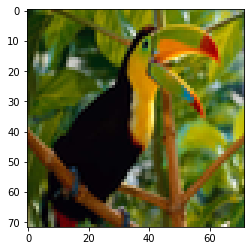

torch.Size([3, 72, 72])


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [ ]:
image = ImageFitting(fname,factor)
sidelength1=int(h/factor)
sidelength2=int(w/factor)
dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True)



img_siren.cuda()

Train

Step 0, Total loss 0.399366
(288, 288, 3)
(288, 288, 3)


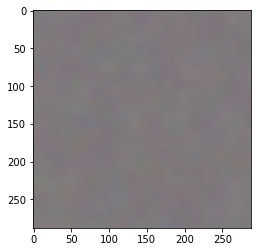

<ipython-input-10-08b823be3b1a>:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM = ssim(gt,outputimg , multichannel=True)


ssim =  0.3351284
psnr =  9.942697534103836
time =  7.463362455368042


Step 500, Total loss 0.000032
(288, 288, 3)
(288, 288, 3)


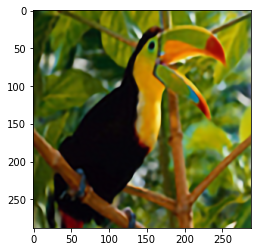

ssim =  0.94474715
psnr =  30.555195840246313
time =  18.085572004318237


In [ ]:
#total steps
total_steps = 500
#test steps
steps_til_summary = 500

i=0
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
start_time = time.time()
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
for step in range(total_steps+1):
    model_output, coords = img_siren(model_input)
    model_outputnew=(downsampler(model_output.view(sidelength1*factor,sidelength2*factor,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3) 
    loss = ((model_outputnew - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))       
    
        outputimg=model_output.cpu().view(sidelength1*factor,sidelength2*factor,3).detach().numpy()
        gt=(np.array( Image.open(fname)).astype(np.float32)/255)       
        print(gt.shape)
        print(outputimg.shape)
        outputimg=(outputimg+1)/2  
        plt.imshow((model_output.cpu().view(sidelength1*factor,sidelength2*factor,3).detach().numpy()+1)/2)
        plt.pause(0.1)
        #print metric
        SSIM = ssim(gt,outputimg , multichannel=True)
        print("ssim = ", SSIM)          
        PSNR = psnr(gt,outputimg)
        print("psnr = ", PSNR)
        end_time = time.time()
        print("time = ",(end_time - start_time))
        i=i+1

    optim.zero_grad()
    loss.backward()
    optim.step()




 
plt.show()